In [1]:
import ee
%matplotlib inline
import math
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import datetime, calendar

plt.style.use("seaborn-darkgrid")

#ee.Authenticate()
ee.Initialize()

C:\Users\theodore.wong\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\theodore.wong\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\theodore.wong\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [32]:
MODEL_INFO = {'UKESM1-0-LL': 'HadAM',
 'NorESM2-MM': 'CCM',
 'NorESM2-LM': 'CCM',
 'MRI-ESM2-0': 'UCLA GCM',
 'MPI-ESM1-2-LR': 'ECMWF',
 'MPI-ESM1-2-HR': 'ECMWF',
 'MIROC6': 'MIROC',
 'MIROC-ES2L': 'MIROC',
 'KIOST-ESM': 'GFDL',
 'KACE-1-0-G': 'HadAM',
 'IPSL-CM6A-LR': 'IPSL',
 'INM-CM5-0': 'INM',
 'INM-CM4-8': 'INM',
 'HadGEM3-GC31-MM': 'HadAM',
 'HadGEM3-GC31-LL': 'HadAM',
 'GFDL-ESM4': 'GFDL',
 'GFDL-CM4_gr2': 'GFDL',
 'GFDL-CM4': 'GFDL',
 'FGOALS-g3': 'CCM',
 'EC-Earth3-Veg-LR': 'ECMWF',
 'EC-Earth3': 'ECMWF',
 'CanESM5': 'CanAM',
 'CNRM-ESM2-1': 'ECMWF',
 'CNRM-CM6-1': 'ECMWF',
 'CMCC-ESM2': 'CCM',
 'CMCC-CM2-SR5': 'CCM',
 #'BCC-CSM2-MR': 'CCM',
 'ACCESS-ESM1-5': 'HadAM',
 'ACCESS-CM2': 'HadAM',
 'TaiESM1': 'CCM',
}

EXCLUDED_MODELS = ['GFDL-CM4_gr2','ERA5']

MODELS = [i for i in MODEL_INFO.keys() if not i in EXCLUDED_MODELS]


CAMPINAS_LATLON = (-22.907104, -47.063240)  # Campinas

HIST_START = 1980
HIST_END = 2014
FUTURE_START = 2050
FUTURE_END = 2070

PERCENTILE_STARTYEAR = 1980
PERCENTILE_ENDYEAR = 2019

STUDY_THRESH = 40

NUM_BEST_MODELS = 3

shift_years = False

In [30]:
VARIABLES = {
    'tasmax': {
        'era_varname': 'maximum_2m_air_temperature',
        'nex_transform': lambda x: x - 273.5,
        'era_transform': lambda x: x - 273.5
    },
    'tasmin': {
        'era_varname': 'minimum_2m_air_temperature',
        'nex_transform': lambda x: x - 273.5,
        'era_transform': lambda x: x - 273.5
    },
    'pr': {
        'era_varname': 'total_precipitation',
        'nex_transform': lambda x: x * 86400,
        'era_transform': lambda x: x * 1000
    },
    'hurs': {
        'era_varname': None,
       'nex_transform': lambda x: x,
        'era_transform': lambda x: x
    }
}

In [48]:
YEARLENGTH = 366

In [36]:
def calendardate_percentiles(nex_varname, q, latlon, sh_hem=False):
    era_varname = VARIABLES[nex_varname]['era_varname']
    hist_start = PERCENTILE_STARTYEAR
    hist_end = PERCENTILE_ENDYEAR
    allyears = []
    for year in range(hist_start, hist_end):
        allyears.append(VARIABLES[nex_varname]['era_transform'](get_var(era_varname, 'ERA5', latlon, start_year=year, end_year=year, southern_hem=False)))
    if not sh_hem:
        return np.percentile(np.vstack(allyears), q, axis=0)
    else:
        res = np.percentile(np.vstack(allyears), q, axis=0)
        return np.concatenate([res[152:], res[:152]])

def wholeyear_percentile(nex_varname, q, latlon):
    era_varname = VARIABLES[nex_varname]['era_varname']
    hist_start = PERCENTILE_STARTYEAR
    hist_end = PERCENTILE_ENDYEAR
    allyears = []
    for year in range(hist_start, hist_end):
        allyears.append(VARIABLES[nex_varname]['era_transform'](get_var(era_varname, 'ERA5', latlon, start_year=year, end_year=year, southern_hem=False)))
    return np.percentile(np.concatenate(allyears).flatten(), q)

def yearextreme_percentile(nex_varname, q, latlon, wantmax):
    era_varname = VARIABLES[nex_varname]['era_varname']
    hist_start = PERCENTILE_STARTYEAR
    hist_end = PERCENTILE_ENDYEAR
    allyears = []
    for year in range(hist_start, hist_end):
        allyears.append([np.min, np.max][int(wantmax)](VARIABLES[nex_varname]['era_transform'](get_var(era_varname, 'ERA5', latlon, start_year=year, end_year=year, southern_hem=False))))
    return np.percentile(np.array(allyears), q)

def d2j(datestring):
    d = datetime.date.fromisoformat(datestring)
    jday = d.timetuple().tm_yday
    if calendar.isleap(d.year) and jday > 59:
        jday -= 1
    return jday

def get_rmsd(d1, d2):
    c1 = seasonal_means(d1)
    c2 = seasonal_means(d2)
    return np.sqrt(np.mean(np.sum((c1 - c2)**2)))

def count_runs(tf_array, min_runsize):
    falses = np.zeros(tf_array.shape[0]).reshape((tf_array.shape[0],1))
    extended_a = np.concatenate([[0], tf_array, [0]])
    df = np.diff(extended_a)
    starts = np.nonzero(df == 1)[0]
    ends = np.nonzero(df == -1)[0]
    count = 0
    for idx in range(starts.size):
        if ends[idx] - starts[idx] >= min_runsize:
            count += 1
    return count


def longest_run(tf_array):
    if np.sum(tf_array) == 0:
        return 0
    falses = np.zeros(tf_array.shape[0]).reshape((tf_array.shape[0],1))
    extended_a = np.concatenate([[0], tf_array, [0]])
    df = np.diff(extended_a)
    starts = np.nonzero(df == 1)[0]
    ends = np.nonzero(df == -1)[0]
    durations = ends - starts
    return max(durations)

def get_var(varname, model, latlon, start_year, end_year, southern_hem=False, scenario='ssp585'):
    print(varname, model)
    if start_year < 2015 and end_year < 2015:
        scenario = 'historical'

    if model != 'ERA5' and start_year < 2015 and end_year >= 2015:
        raise Exception("Requesting hist and non-hist variables in one query")
    if model == 'ERA5':
        dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
    else:
        dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model)).filter(ee.Filter.eq('scenario', [scenario, 'historical'][int(end_year<2015)]))
    gee_geom = ee.Geometry.Point((latlon[1], latlon[0]))
    if not southern_hem:
        data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-01-01'.format(start_year), '{0}-01-01'.format(end_year+ 1)))
        result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        return removeLeapDays(np.array(result), start_year, end_year, southern_hem)
    else:
        data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-07-01'.format(start_year-1), '{0}-07-01'.format(end_year)))
        result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        return removeLeapDays(np.array(result), start_year, end_year, southern_hem)
    
def quarters(d, start_year, end_year, southern_hem=False):
    q2 = []  # 60-151
    q3 = []  # 152-243
    q4 = []  # 244-334
    q1 = []  # 335-59
    if not southern_hem:
        jan1_idx = 365
        for year in range(start_year, end_year):
            tmp = np.concatenate((d[jan1_idx - 365 : jan1_idx - 365 + 60], d[jan1_idx + 335 : jan1_idx + 365]), axis=0)
            q1.append(tmp)
            q2.append(d[jan1_idx + 60 : jan1_idx + 152])
            q3.append(d[jan1_idx + 152 : jan1_idx + 244])
            q4.append(d[jan1_idx + 244 : jan1_idx + 335])

            jan1_idx += 365 + [0, 0][int(False and calendar.isleap(year))]
        mam_res = np.vstack(q2)
        jja_res = np.vstack(q3)
        son_res = np.vstack(q4)
        djf_res = np.vstack(q1)
    else:
        jul1_idx = 365
        for year in range(start_year, end_year):
            tmp = np.concatenate((d[jul1_idx - 365 : jul1_idx - 365 + 60], d[jul1_idx + 335 : jul1_idx + 365]), axis=0)
            q3.append(tmp)
            q4.append(d[jul1_idx + 60 : jul1_idx + 152])
            q1.append(d[jul1_idx + 152 : jul1_idx + 244])
            q2.append(d[jul1_idx + 244 : jul1_idx + 335])

            jul1_idx += 365 + [0, 0][int(False and calendar.isleap(year))]
        mam_res = np.vstack(q4)
        jja_res = np.vstack(q1)
        son_res = np.vstack(q2)
        djf_res = np.vstack(q3)
    return mam_res, jja_res, son_res, djf_res
    
def seasonal_means(d):
    q = quarters(d, HIST_START, HIST_END)
    return np.array([np.mean(q[0], axis=1), np.mean(q[1], axis=1), np.mean(q[2], axis=1), np.mean(q[3], axis=1)])

def calibration_function(hist_obs, hist_mod):
# Calibration functions are P-P plots of historical and modeled values

    source = np.sort(hist_obs.flatten())
    target= np.sort(hist_mod.flatten())
   
    if (np.max(source) == 0 and np.min(source) == 0):
        return np.arange(0, target.size) / target.size
    if (np.max(target) == 0 and np.min(target) == 0):
        return np.arange(0, source.size) / source.size
    new_indices = []

    for target_idx, target_value in enumerate(target):
        if target_idx < len(source):
            source_value = source[target_idx]
            if source_value > target[-1]:
                new_indices.append(target.size - 1)
            else:
                new_indices.append(np.argmax(target >= source_value))
    return np.array(new_indices) / source.size

def calibrate_component(uncalibrated_data, calibration_fxn):
    N = len(uncalibrated_data)
    unsorted_uncalib = [(i, idx) for idx, i in enumerate(uncalibrated_data)]
    sorted_uncalib = sorted(unsorted_uncalib)
    result = [0] * N
    for j in range(N):
        X_j = j / (N + 1)
        Y_jprime = calibration_fxn[math.floor(X_j * len(calibration_fxn))]
        jprime = math.floor(Y_jprime * (N + 1))
        result[sorted_uncalib[j][1]] = sorted_uncalib[min(len(sorted_uncalib)-1, jprime)][0]
    
    return result

def calibrate(uncalibrated_data, calibration_fxn):
    mam = []
    jja = []
    son = []
    djf = []
    mam_idx = []
    jja_idx = []
    son_idx = []
    djf_idx = []
    for idx, i in enumerate(uncalibrated_data):
        if idx % 365 >= 60 and idx % 365 < 152:
            mam.append(uncalibrated_data[idx])
            mam_idx.append(idx)
        elif idx % 365 >= 152 and idx % 365 < 244:
            jja.append(uncalibrated_data[idx])
            jja_idx.append(idx)
        elif idx % 365 >= 244 and idx % 365 < 335:
            son.append(uncalibrated_data[idx])
            son_idx.append(idx)
        else:
            djf.append(uncalibrated_data[idx])
            djf_idx.append(idx)
    
    mam_calib = calibrate_component(np.array(mam), calibration_fxn[0])
    jja_calib = calibrate_component(np.array(jja), calibration_fxn[1])
    son_calib = calibrate_component(np.array(son), calibration_fxn[2])
    djf_calib = calibrate_component(np.array(djf), calibration_fxn[3])
    
    result = [0] * len(uncalibrated_data)
    for i in range(len(mam_idx)):
        result[mam_idx[i]] = mam_calib[i]
    for i in range(len(jja_idx)):
        result[jja_idx[i]] = jja_calib[i]
    for i in range(len(son_idx)):
        result[son_idx[i]] = son_calib[i]
    for i in range(len(djf_idx)):
        result[djf_idx[i]] = djf_calib[i]

    return np.array(result)

def get_gamma(count, size):
    return np.random.gamma(shape = count + 0.5, size=size)
def get_beta(count, num, size):
    return np.random.beta(a = count + 0.5, b = num - count + 0.5, size=size)

In [163]:
class Hazard:
    def get_estimates(self, latlon, start_year, end_year, datasets, calib_fxns):
        def nonemin(a, b):
            if a is None or b is None:
                return None
            return min(a, b)
        def nonemax(a, b):
            if a is None or b is None:
                return None
            return max(a, b)
        
        sh_year = int(latlon[0] < 0)
        fut_mod = {}
        varnames = self.varname.split('+')
        for varname in varnames:
            for model in calib_fxns[varname].keys():
                ds = datasets[varname][model]

                fut_mod[(varname, model)] = ds
        best_models = []
        for idx in range(NUM_BEST_MODELS):
            modelplus = '+'.join([list(calib_fxns[varname].keys())[idx] for varname in varnames])
            best_models.append(modelplus)

        
        qs = {}
        para_res = {}
        for modelplus in best_models:
            calib_data = []
            for idx, varname in enumerate(varnames):
                model = modelplus.split('+')[idx]
                calib_data.append(np.array(calibrate(fut_mod[(varname, model)], calib_fxns[varname][model])))


            countdist = self.val_dist([cd[[0,152][int(not sh_year)]:[len(cd),-213][int(not sh_year)]] for cd in calib_data])
            post_distr = {}
            freq_dist = []
            val_dist = []
        
            for mag in countdist:
                count = countdist[mag]
                binomial_ps = get_beta(count, (end_year - start_year + 1), 1000)
                draws = np.random.binomial(mag, binomial_ps, 1000)
                val_dist += math.floor(np.sum(draws)) * [mag]
                freq_dist.append(math.floor(np.sum(draws)))
 
            cdf_y = np.cumsum(np.array(freq_dist) / (1000 * len(list(countdist.keys()))))
            qs[modelplus] = np.interp([.25, .5, .75], cdf_y, list(countdist.keys()))
            para_res[modelplus] = np.array(val_dist)
        
        return {modelplus:[np.mean(para_res[modelplus])- (1.96 * np.std(para_res[modelplus])), np.mean(para_res[modelplus]), np.mean(para_res[modelplus]) + (1.96 * np.std(para_res[modelplus])),qs[modelplus][0], qs[modelplus][1], qs[modelplus][2], 0, 0] for modelplus in best_models}

class Tempwave_simple(Hazard):
    def __init__(self, hazname, varname, min_duration, threshold, want_gte=True):
        if type(threshold) == np.ndarray and threshold.size % 365 != 0:
            raise Exception('Comparison array length is not an integer multiple of 365')
        self.hazname = hazname
        self.varname = varname
        self.want_gte = want_gte
        self.min_duration = min_duration
        self.threshold = threshold  # May be scalar or 365-long array
        self.probmodel = 'Poisson'
    def tf_array(self, datalist):
        data = datalist[0]
        '''if type(self.threshold) in (float, int, np.float64, np.int32):
            threshold = self.threshold
        else:   # type is np array
            threshold = np.array([])
            while threshold.size < data.size:
                threshold = np.concatenate([threshold, self.threshold])'''
        if self.want_gte:
           return data >= self.threshold
        else:
            return data <= self.threshold
    def baseline(self, data, sh_year):
        if sh_year:
            data = data[152:-213]
        if self.want_gte:
            tfarray = data >= self.threshold
        else:
            tfarray = data <= self.threshold
        return count_runs(tfarray, self.min_duration)
    def val_dist(self, datalist):
        tfarray = self.tf_array(datalist)
        tfarray = tfarray.reshape(tfarray.size//365, 365)
        vals = np.apply_along_axis(count_runs, 1, tfarray, self.min_duration)
        
        result_dist = {}
        for val in np.unique(vals):
            result_dist[val] = np.sum(vals == val)
        return result_dist

    def maxval_dist(self, datalist):
        tfarray = self.tf_array(datalist)
        tfarray = tfarray.reshape(tfarray.size//365, 365)
        vals = np.apply_along_axis(longest_run, 1, tfarray)
        result_dist = {}
        for val in np.unique(vals):
            result_dist[val] = np.sum(vals == val)
        return result_dist
    def baseline_maxval(self, loc, sh_year):
        data = loc.hist_observed[self.varname]
        if sh_year:
            data = data[152:-213]
        if self.want_gte:
            tfarray = data >= self.threshold
        else:
            tfarray = data <= self.threshold
        byyear = tfarray.reshape(data.size//365, 365)
        vals = np.apply_along_axis(longest_run, 1, byyear)
        result_dist = {}
        for val in np.unique(vals):
            result_dist[val] = np.sum(vals == val)
        return result_dist
    
    
class Heatwave_highlow(Hazard):
    def __init__(self, hazname, hightemp, lowtemp, min_duration):
        self.hazname = hazname
        self.varname = 'tasmax+tasmin'
        self.min_duration = min_duration
        self.hightemp = hightemp
        self.lowtemp = lowtemp
        self.probmodel = 'Poisson'
    def tf_array(self, datalist):
        data_tx = datalist[0]
        data_tn = datalist[1]
        if type(self.hightemp) in (float, int, np.float64, np.int32):
            high_threshold = self.hightemp
        else:   # type is np array
            high_threshold = np.array([])
            while high_threshold.size < data_tx.size:
                high_threshold = np.concatenate([high_threshold, self.hightemp])
        if type(self.lowtemp) in (float, int, np.float64, np.int32):
            low_threshold = self.lowtemp
        else:   # type is np array
            low_threshold = np.array([])
            while low_threshold.size < data_tn.size:
                low_threshold = np.concatenate([low_threshold, self.lowtemp])
        tf_array_tx = data_tx >= high_threshold
        tf_array_tn = data_tn >= low_threshold
        return tf_array_tx * tf_array_tn
    def val_dist(self, datalist):
        tfarray = self.tf_array(datalist)
        tfarray = tfarray.reshape(tfarray.size//365, 365)
        vals = np.apply_along_axis(count_runs, 1, tfarray, self.min_duration)
        result_dist = {}
        for val in np.unique(vals):
            result_dist[val] = np.sum(vals == val)
        return result_dist
    
    def maxval_dist(self, datalist):
        tfarray = tf_array(datalist)
        tfarray = tfarray.reshape(tfarray.size // 365, 365)
        vals = np.apply_along_axis(longest_run, 1, tfarray)
        result_dist = {}
        for val in np.unique(vals):
            result_dist[val] = np.sum(vals == val)
        return result_dist
        
    def baseline(self, data, sh_year):
        data_tx = data[0]
        data_tn = data[1]
        if sh_year:
            data_tx = data_tx[152:-213]
            data_tn = data_tn[152:-213]
        if type(self.hightemp) in (float, int, np.float64, np.int32):
            high_threshold = self.hightemp
        else:   # type is np array
            high_threshold = np.array([])
            while high_threshold.size < data_tx.size:
                high_threshold = np.concatenate([high_threshold, self.hightemp])
        if type(self.lowtemp) in (float, int, np.float64, np.int32):
            low_threshold = self.lowtemp
        else:   # type is np array
            low_threshold = np.array([])
            while low_threshold.size < data_tn.size:
                low_threshold = np.concatenate([low_threshold, self.lowtemp])
        tf_array_tx = data_tx >= high_threshold
        tf_array_tn = data_tn >= low_threshold
        return count_runs(tf_array_tx * tf_array_tn, self.min_duration)
    def baseline_maxval(self, loc, sh_year):
        data_tx = loc.hist_observed['tasmax']
        data_tn = loc.hist_observed['tasmin']
        if sh_year:
            data_tx = data_tx[152:-213]
            data_tn = data_tn[152:-213]
        if type(self.hightemp) in (float, int, np.float64, np.int32):
            high_threshold = self.hightemp
        else:   # type is np array
            high_threshold = np.array([])
            while high_threshold.size < data_tx.size:
                high_threshold = np.concatenate([high_threshold, self.hightemp])
        if type(self.lowtemp) in (float, int, np.float64, np.int32):
            low_threshold = self.lowtemp
        else:   # type is np array
            low_threshold = np.array([])
            while low_threshold.size < data_tn.size:
                low_threshold = np.concatenate([low_threshold, self.lowtemp])
        tf_array_tx = data_tx >= high_threshold
        tf_array_tn = data_tn >= low_threshold

class ThresholdDays(Hazard):
    def __init__(self, hazname, varname, var_threshold, want_max):
        self.hazname = hazname
        self.varname = varname
        self.var_threshold = var_threshold
        self.want_max = want_max
        self.probmodel = 'binomial'

    def val_dist(self, datalist):
        data = datalist[0]
        if data.size % 365 != 0:
            raise Exception('Data array length is not an integer multiple of 365')   
        byyear = data.reshape(data.size // 365, 365)
        
        if self.want_max:
            vals = np.sum(byyear >= self.var_threshold, axis=1)
        else:
            vals = np.sum(byyear <= self.var_threshold, axis=1)
        result_dist = {}
        for val in np.unique(vals):
            result_dist[val] = np.sum(vals == val)
        return result_dist
    
    def baseline(self, data, sh_year):
        if self.want_max:
            return np.sum(data >= self.var_threshold)
        else:
            return np.sum(data <= self.var_threshold)
        
class Dryduration_seasonal(Hazard):
    def __init__(self, hazname, startdate, enddate, sh_year):
        self.hazname = hazname
        self.varname = 'pr'
        self.startdate = startdate
        self.enddate = enddate
        self.sh_year = sh_year
        self.probmodel = 'binomial'
        
    def tf_array(self, datalist):
        
        data = datalist[0] == 0
        if data.size % 365 != 0:
            raise Exception('Data array length is not an integer multiple of 365')   
        byyear = data.reshape(data.size//365, 365)
        
        start_jday = d2j('1999-{0}'.format(self.startdate)) - [0, 182][int(self.sh_year)]
        end_jday = d2j('1999-{0}'.format(self.enddate)) - [0, 182][int(self.sh_year)]
        if end_jday < start_jday:
            end_jday += 365
        inseason_onerow = [((i >= start_jday)and(i <= end_jday)) for i in range(365)]
        inseason = np.array(inseason_onerow * (data.size//365))
        inseason = inseason.reshape(data.size//365, 365)
        return byyear * inseason


    def val_dist(self, datalist):
        
        byyear = self.tf_array(datalist)
        vals = np.apply_along_axis(longest_run, 1, byyear)
        result_dist = {}
        for val in np.unique(vals):
            result_dist[val] = np.sum(vals == val)
        return result_dist


    def baseline(self, data, sh_year):
        data = data == 0
        if data.size % 365 != 0:
            raise Exception('Data array length is not an integer multiple of 365')   
        byyear = data.reshape(data.size//365, 365)
        
        start_jday = d2j('1999-{0}'.format(self.startdate)) - [0, 182][int(self.sh_year)]
        end_jday = d2j('1999-{0}'.format(self.enddate)) - [0, 182][int(self.sh_year)]
        if end_jday < start_jday:
            end_jday += 365
        inseason = [((i >= start_jday)and(i <= end_jday)) for i in range(365)]
        byyear = byyear * ([inseason]*(data.size//365))
        longest_runs = np.apply_along_axis(longest_run, 1, byyear)
        return np.mean(longest_runs)
    
class Drycount_seasonal(Hazard):
    def __init__(self, hazname, startdate, enddate, sh_year):
        self.hazname = hazname
        self.varname = 'pr'
        self.startdate = startdate
        self.enddate = enddate
        self.sh_year = sh_year
        self.probmodel = 'binomial'
        
    def tf_array(self, datalist):
        
        data = datalist[0] == 0
        if data.size % 365 != 0:
            raise Exception('Data array length is not an integer multiple of 365')   
        byyear = data.reshape(data.size//365, 365)
        
        start_jday = d2j('1999-{0}'.format(self.startdate)) - [0, 182][int(self.sh_year)]
        end_jday = d2j('1999-{0}'.format(self.enddate)) - [0, 182][int(self.sh_year)]
        if end_jday < start_jday:
            end_jday += 365
        inseason_onerow = [((i >= start_jday)and(i <= end_jday)) for i in range(365)]
        inseason = np.array(inseason_onerow * data.size//365)
        return (byyear * inseason) == 0


    
    def val_dist(self, datalist):
        tfarray = self.tf_array(datalist)
        vals = np.apply_along_axis(count_runs, 1, tfarray, self.min_duration)
        
        result_dist = {}
        for val in np.unique(vals):
            result_dist[val] = np.sum(vals == val)
        return result_dist

    def baseline(self, data, sh_year):
        data = data == 0
        if data.size % 365 != 0:
            raise Exception('Data array length is not an integer multiple of 365')   
        byyear = data.reshape(data.size//365, 365)
        
        start_jday = d2j('1999-{0}'.format(self.startdate)) - [0, 182][int(self.sh_year)]
        end_jday = d2j('1999-{0}'.format(self.enddate)) - [0, 182][int(self.sh_year)]
        if end_jday < start_jday:
            end_jday += 365
        inseason = [((i >= start_jday)and(i <= end_jday)) for i in range(365)]
        byyear = byyear * ([inseason]*(data.size//365))
        runcount = np.apply_along_axis(count_runs, 1, byyear)
        return np.mean(runcount)

class Annual_val(Hazard):
    def __init__(self, hazname, varname, aggtype):
        self.hazname = hazname
        self.varname = varname
        self.aggtype = aggtype
        self.probmodel = 'binomial'
        
    def val_dist(self, datalist):
        data = datalist[0]
        byyear = data.reshape(data.size//365, 365)
        if self.aggtype == 'sum':
            vals = np.sum(byyear, axis=1)
        elif self.aggtype == 'mean':
            vals = np.mean(byyear, axis=1)
        elif self.aggtype == 'max':
            vals = np.max(byyear, axis=1)
        elif self.aggtype == 'min':
            vals = np.min(byyear, axis=1)
        result_dist = {}
        for val in np.unique(vals):
            result_dist[val] = np.sum(vals == val)
        return result_dist
        
    def baseline(self, data, sh_year):
        byyear = data.reshape(data.size//365, 365)
        if self.aggtype == 'sum':
            return np.mean(np.sum(byyear, axis=1))
        elif self.aggtype == 'mean':
            return np.mean(np.mean(byyear, axis=1))
        elif self.aggtype == 'max':
            return np.mean(np.max(byyear, axis=1))
        elif self.aggtype == 'min':
            return np.mean(np.min(byyear, axis=1))
        
class Seasonal_val(Hazard):
    def __init__(self, hazname, varname, aggtype, startdate, enddate, sh_year):
        self.hazname = hazname
        self.varname = varname
        self.aggtype = aggtype
        self.startdate = startdate
        self.enddate = enddate
        self.sh_year = sh_year
        self.probmodel = 'binomial'
        
    def val_dist(self, datalist):
        data = datalist[0]
        byyear = data.reshape(data.size//365, 365)
        start_jday = d2j('1999-{0}'.format(self.startdate)) - [0, 182][int(self.sh_year)]
        end_jday = d2j('1999-{0}'.format(self.enddate)) - [0, 182][int(self.sh_year)]
        if end_jday < start_jday:
            end_jday += 365
        inseason_onerow = [((i >= start_jday)and(i <= end_jday)) for i in range(365)]
        inseason = np.array([inseason_onerow]*(data.size//365))
        byyear = byyear * inseason
        if self.aggtype == 'sum':
            vals = np.sum(byyear, axis=1)
        elif self.aggtype == 'mean':
            vals = np.mean(byyear, axis=1)
        elif self.aggtype == 'max':
            vals = np.max(byyear, axis=1)
        elif self.aggtype == 'min':
            vals = np.min(byyear, axis=1)
        result_dist = {}
        for val in np.unique(vals):
            result_dist[val] = np.sum(vals == val)
        print(vals)
        return result_dist
        
    def baseline(self, data, sh_year):
        byyear = data.reshape(data.size//365, 365)
        
        start_jday = d2j('1999-{0}'.format(self.startdate)) - [0, 182][int(self.sh_year)]
        end_jday = d2j('1999-{0}'.format(self.enddate)) - [0, 182][int(self.sh_year)]
        if end_jday < start_jday:
            end_jday += 365
        inseason = [((i >= start_jday)and(i <= end_jday)) for i in range(365)]
        byyear = byyear * ([inseason]*(data.size//365))
        
        if self.aggtype == 'sum':
            return np.mean(np.sum(byyear, axis=1))
        elif self.aggtype == 'mean':
            return np.mean(np.mean(byyear, axis=1))
        elif self.aggtype == 'max':
            return np.max(np.mean(byyear, axis=1))
        elif self.aggtype == 'min':
            return np.mean(np.min(byyear, axis=1))
        

In [111]:
def removeLeapDays(arr, start_year, end_year, southern_hem):
    indices_to_remove = []
    for year in range(start_year, end_year + 1):
        if calendar.isleap(year):
            indices_to_remove.append(((year-start_year) * 365) + [0,183][int(southern_hem)] + len(indices_to_remove) + 59)
    return np.delete(arr, indices_to_remove)

def get_histmod_oneloc(varname, model, latlon, start_year, end_year):
    dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model)).filter(ee.Filter.eq('scenario', 'historical'))
    gee_geom = ee.Geometry.Point((latlon[1], latlon[0]))
    data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-01-01'.format(start_year), '{0}-01-01'.format(end_year+ 1)))
    result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
    return VARIABLES[varname]['nex_transform'](np.array(result))

def get_histobs_oneloc(varname, latlon, start_year, end_year):
    def relhum(T, Tdp):
        T = T.astype('float64')
        Tdp = Tdp.astype('float64')
        numerator = np.exp(17.625 * Tdp / (243.04 + Tdp))
        denominator = np.exp(17.625 * T / (243.04 + T))
        return 100 * numerator / denominator

    def get_eradata(varname, start_year, end_year):
        dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
        gee_geom = ee.Geometry.Point((latlon[1], latlon[0]))
        data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-01-01'.format(start_year), '{0}-01-01'.format(end_year+ 1)))
        success = False
        while not success:
            try:
                d = data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()
                success = True
            except:
                print('\nRetrying')
        result = [i[4] for i in d[1:]]
        return np.array(result)
    
    if varname == 'hurs':
        success = False
        era_dewpoint = get_eradata('dewpoint_2m_temperature', HIST_START, HIST_END)-273.15
        era_maxtemp = get_eradata('maximum_2m_air_temperature', HIST_START, HIST_END)-273.15
        hist_obs = relhum(era_maxtemp, era_dewpoint)
    elif varname == 'pr':
        hist_obs = get_eradata('total_precipitation', HIST_START, HIST_END) * 1000
    elif varname == 'tasmax':
        hist_obs = get_eradata('maximum_2m_air_temperature', HIST_START, HIST_END)-273.15
    else:    # varname == 'tasmin'
        hist_obs = get_eradata('minimum_2m_air_temperature', HIST_START, HIST_END)-273.15
    return hist_obs

def get_futmods_oneloc_gee(varname, scenario, model, lat, lon, southern_hem, start_year, end_year):
    dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model)).filter(ee.Filter.eq('scenario', scenario))
    gee_geom = ee.Geometry.Point((lon, lat))
    if start_year >= 2015:
        if southern_hem:
            data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-07-01'.format(start_year-1), '{0}-07-01'.format(end_year)))
        else:
            data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-01-01'.format(start_year), '{0}-01-01'.format(end_year+ 1)))
        result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
    else:
        hist_dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model)).filter(ee.Filter.eq('scenario', 'historical'))
        if southern_hem:
            hist_part = hist_dataset.select(varname).filter(ee.Filter.date('{0}-07-01'.format(start_year-1), '2015-01-01'))
            ssp_part = dataset.select(varname).filter(ee.Filter.date('2015-01-01', '{0}-07-01'.format(end_year)))
        else:
            hist_part = hist_dataset.select(varname).filter(ee.Filter.date('{0}-01-01'.format(start_year), '2015-01-01'))
            ssp_part = dataset.select(varname).filter(ee.Filter.date('2015-01-01'.format(start_year-1), '{0}-01-01'.format(end_year+ 1)))
        hist_result = [i[4] for i in hist_part.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        ssp_result = [i[4] for i in ssp_part.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        result = hist_result + ssp_result
    d =  VARIABLES[varname]['nex_transform'](np.array(result))
    return removeLeapDays(d, start_year, end_year, southern_hem)

In [28]:
def get_calibfxns(varname, latlon, start_year, end_year):
    hist_obs = get_histobs_oneloc(varname, latlon, start_year, end_year)
    hist_mods = {}
    rmsds = []
    for model in MODELS:
        hist_mod = get_histmod_oneloc(varname, model, latlon, start_year, end_year)
        hist_mods[model] = hist_mod
        rmsds.append((get_rmsd(hist_obs, hist_mod), model))
    rmsds.sort()
    best_models = []
    families = []
    idx = 0
    while len(best_models) < 3:
        if not MODEL_INFO[rmsds[idx][1]] in families:
            best_models.append(rmsds[idx][1])
            families.append(MODEL_INFO[rmsds[idx][1]])
        idx += 1

# Get calibration functions
    calib_fxns = {}
    for model in best_models:
        o_quarters = quarters(hist_obs, HIST_START, HIST_END)
        m_quarters = quarters(hist_mods[model], HIST_START, HIST_END)
        calib_fxns[model] = [calibration_function(o_quarters[i].flatten(), m_quarters[i].flatten()) for i in range(4)]
    return calib_fxns


In [46]:
def getdata(varnames, scenario, lat, lon, start_year, end_year, best_models):
    return {varname: {model: get_futmods_oneloc_gee(varname, scenario, model, lat, lon, lat < 0, start_year, end_year) for model in best_models[varname]} for varname in varnames}

def do_locationhazard(hazard, datasets, latlon, scenario, start_year, end_year, calib_fxns):
    lat, lon = latlon
    varnames = hazard.varname.split('+')
    return lat, lon, hazard.hazname, scenario, '{0}-{1}'.format(start_year, end_year), hazard.get_estimates(latlon, start_year, end_year, datasets, calib_fxns)

In [ ]:
high_90c = calendardate_percentiles('tasmax', 90, CAMPINAS_LATLON, sh_hem=True)
low_90c = calendardate_percentiles('tasmin', 90, CAMPINAS_LATLON, sh_hem=True)
hot_95y = wholeyear_percentile('tasmax', 95, CAMPINAS_LATLON)
cold_5y = wholeyear_percentile('tasmin', 5, CAMPINAS_LATLON)
cold_10y = wholeyear_percentile('tasmin', 10, CAMPINAS_LATLON)

In [120]:
VARNAMES = ['tasmax', 'tasmin', 'pr', 'hurs']
calib_fxns = {varname: get_calibfxns(varname, (lat, lon), HIST_START, HIST_END) for varname in VARNAMES}
best_models = {varname: list(calib_fxns[varname].keys()) for varname in VARNAMES}

In [164]:
%%time
#futures2 = []
lat, lon = CAMPINAS_LATLON
HAZARDS = [
#    Heatwave_highlow('Heat wave', high_90c, low_90c, 3),
#    ThresholdDays('Days warmer than 25', 'tasmax', 25, True),
#    ThresholdDays('Days warmer than than 95th pctle yearlong', 'tasmax', hot_95y, True),
#    Annual_val('Hottest annual temp', 'tasmax', 'max'),
#    Annual_val('Coldest annual temp', 'tasmin', 'min'),
#    ThresholdDays('Days colder than than 5th pctle yearlong', 'tasmin', cold_5y, False),
#    ThresholdDays('Days colder than than 13', 'tasmin', 13, False),
#    Tempwave_simple('Cold wave (10th pctle yearlong)', 'tasmin', 6, cold_10y, False),
#    Annual_val('Highest daily precip', 'pr', 'max'),
    Seasonal_val('Total precip 1-Dec_31-Mar', 'pr', 'sum', '12-01', '03-31', True),
    #ThresholdDays('Extreme precip days', 'pr', 100, True),
#    Dryduration_seasonal('Longest dry 1-May_30-Sep', '05-01', '09-30', False),
#    Dryduration_seasonal('Longest dry 1-Dec_31-Mar', '12-01', '03-31', True),
]
future_years = [(2020, 2030), (2030, 2040), (2040, 2050)]
scenario = 'ssp585'
results = []
for hazard in HAZARDS:
    for years in future_years:
        start_year, end_year = years
        varnames = hazard.varname.split('+')
        datasets = getdata(varnames, scenario, lat, lon, start_year, end_year, best_models)
        results.append(do_locationhazard(hazard, datasets, (lat, lon), scenario, start_year, end_year, calib_fxns))


[ 942.5264057   834.3417594   851.82568853  683.53622414  911.74669815
 1001.25141893  865.2347817  1098.0548929  1153.97368356 1068.87546467
  752.12810723]
[ 768.96741263 1006.22938191  902.70038371  766.45574892  772.36709839
  578.67781178  745.07365498  771.53366125  868.04238692  822.62783253
  737.76122704]
[705.49589649 736.45954819 898.97917579 718.64075777 949.44075746
 735.40580758 613.77418965 617.38388213 711.84265318 664.29431955
 649.86783209]
[ 762.65869012 1160.95826659  885.54808836  674.5748213  1078.30393657
  996.31252297  849.03805997  936.51337802  896.80498044  962.07894022
  850.70192347]
[738.59075266 791.2005191  925.21616802 713.43620095 947.14499674
 746.81887024 671.63920755 742.34552379 703.90203214 986.3361404
 720.22886007]
[661.77346371 804.05291464 707.03162857 654.54447694 882.63947266
 988.48154962 468.49424474 582.42680078 531.82843358 690.69884947
 535.71814087]
[ 857.71115956 1115.66345919  678.97267864  735.2802659  1099.09325232
  847.57616815 

In [158]:
oname = 'campinas_new.csv'
for res in results:
    lat, lon, hazardname, scenario, years, resdict = res
    for modelplus in resdict.keys():
        with open(oname, 'a') as ofile:
            vals = resdict[modelplus]
            ofile.write('{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11}\n'.format(lat, lon, hazardname, scenario, modelplus, years, vals[0], vals[1], vals[2], vals[3], vals[4], vals[5]))

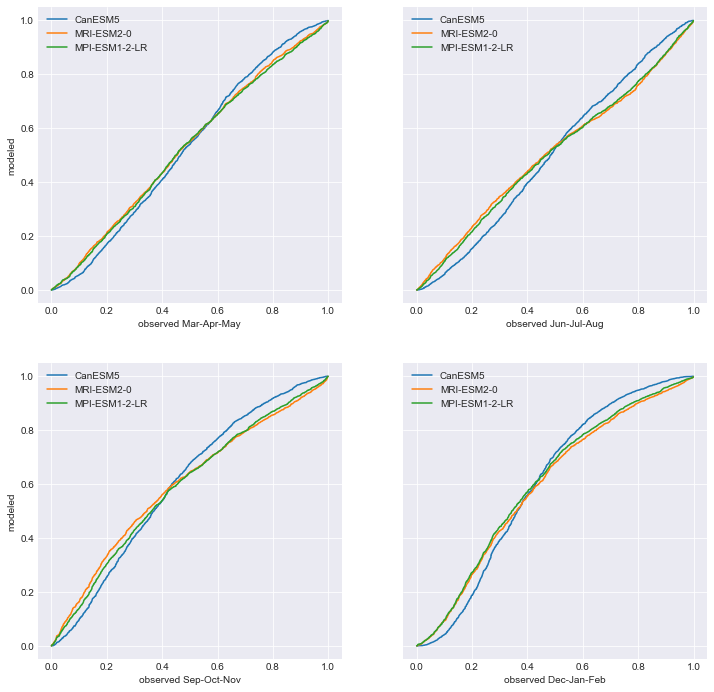

In [168]:
varname = 'tasmax'
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharey=True, figsize=(12, 12))
for i in range(4):
    ax = (ax0, ax1, ax2, ax3)[i]
    for model in calib_fxns[varname]:
        ax.plot([j/(len(calib_fxns[varname][model][i])+1) for j in range(len(calib_fxns[varname][model][i]))], calib_fxns[varname][model][i], label=model)
        ax.set_xlabel('observed {}'.format(['Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov', 'Dec-Jan-Feb'][i]))
        ax.legend()
ax0.set_ylabel('modeled')
ax2.set_ylabel('modeled')
plt.show()

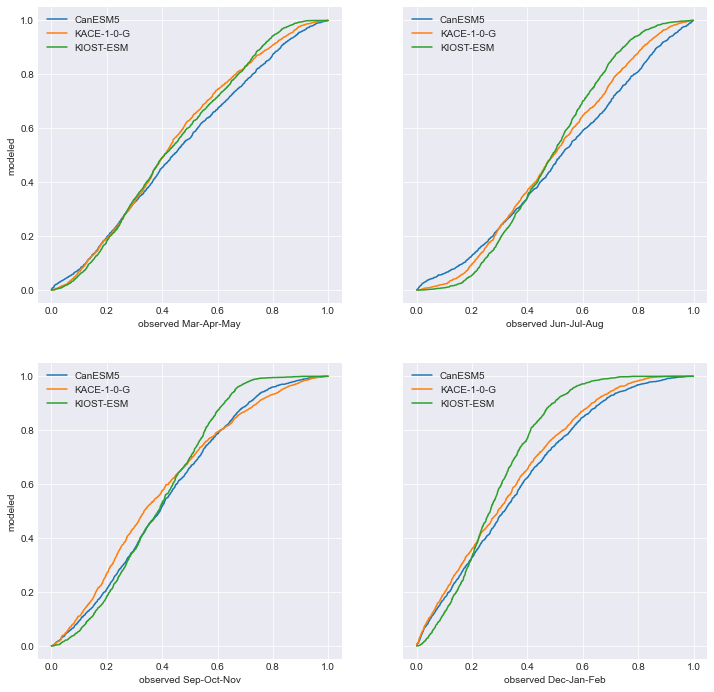

In [169]:
varname = 'tasmin'
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharey=True, figsize=(12, 12))
for i in range(4):
    ax = (ax0, ax1, ax2, ax3)[i]
    for model in calib_fxns[varname]:
        ax.plot([j/(len(calib_fxns[varname][model][i])+1) for j in range(len(calib_fxns[varname][model][i]))], calib_fxns[varname][model][i], label=model)
        ax.set_xlabel('observed {}'.format(['Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov', 'Dec-Jan-Feb'][i]))
        ax.legend()
ax0.set_ylabel('modeled')
ax2.set_ylabel('modeled')
plt.show()

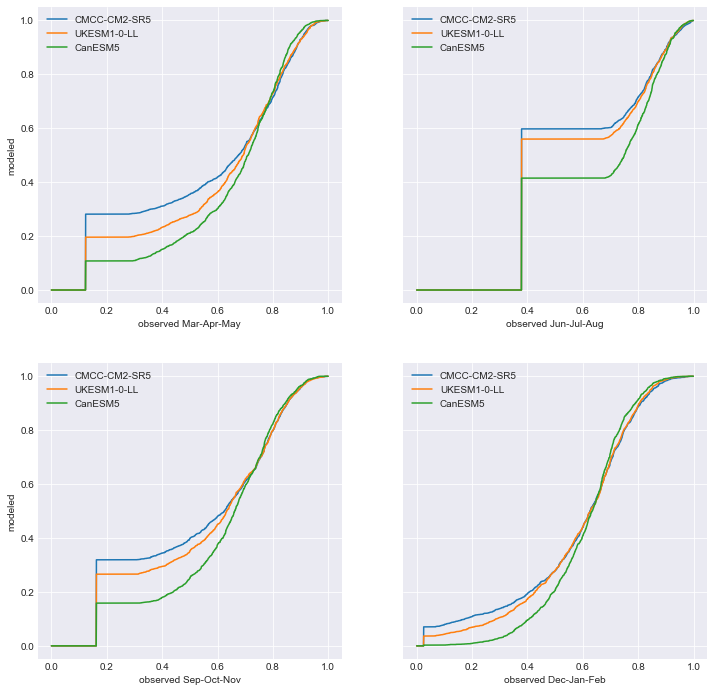

In [170]:
varname = 'pr'
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharey=True, figsize=(12, 12))
for i in range(4):
    ax = (ax0, ax1, ax2, ax3)[i]
    for model in calib_fxns[varname]:
        ax.plot([j/(len(calib_fxns[varname][model][i])+1) for j in range(len(calib_fxns[varname][model][i]))], calib_fxns[varname][model][i], label=model)
        ax.set_xlabel('observed {}'.format(['Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov', 'Dec-Jan-Feb'][i]))
        ax.legend()
ax0.set_ylabel('modeled')
ax2.set_ylabel('modeled')
plt.show()

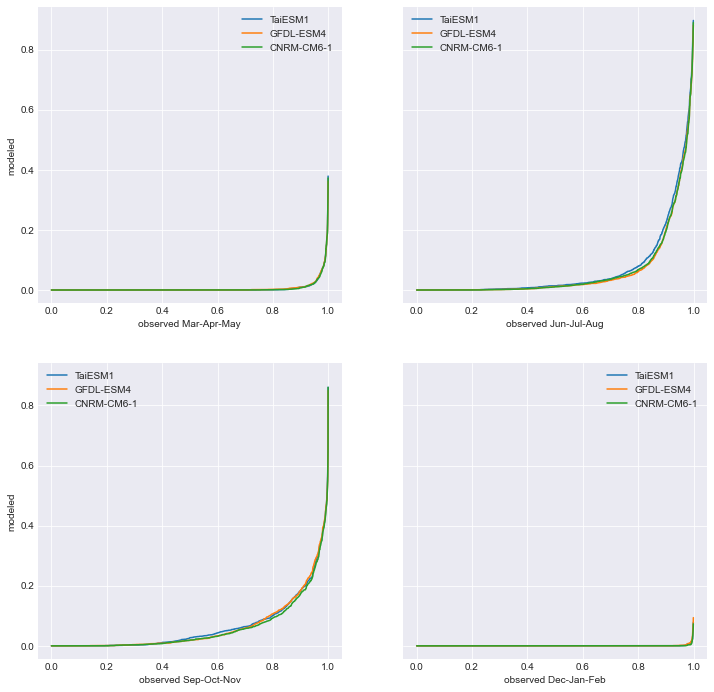

In [171]:
varname = 'hurs'
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharey=True, figsize=(12, 12))
for i in range(4):
    ax = (ax0, ax1, ax2, ax3)[i]
    for model in calib_fxns[varname]:
        ax.plot([j/(len(calib_fxns[varname][model][i])+1) for j in range(len(calib_fxns[varname][model][i]))], calib_fxns[varname][model][i], label=model)
        ax.set_xlabel('observed {}'.format(['Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov', 'Dec-Jan-Feb'][i]))
        ax.legend()
ax0.set_ylabel('modeled')
ax2.set_ylabel('modeled')
plt.show()

In [144]:
resdict[modelplus]

[2.484394127627141,
 5.940532592713609,
 9.396671057800077,
 4.68678629690049,
 5.8782412626832015,
 7.453918495297805,
 0,
 0]

In [37]:
with open('campinas_90thmax-90thmin_bycalendardate.csv', 'w') as ofile:
    ofile.write('day,90th_max,90th_min\n')
    for idx in range(len(high_90c)):
        ofile.write('{0},{1},{2}\n'.format(idx+1, high_90c[idx], low_90c[idx]))

Heat wave
CanESM5 14.104006907813487
BCC-CSM2-MR 14.190571686936817
MRI-ESM2-0 14.20161521070594
BCC-CSM2-MR 9.647748606660912
KACE-1-0-G 9.928105041547472
KIOST-ESM 10.340874862329217
Heat wave
[['CanESM5+BCC-CSM2-MR', array([67, 57, 47, ..., 55, 82, 44])], ['BCC-CSM2-MR+KACE-1-0-G', array([45, 70, 53, ..., 45, 63, 51])], ['MRI-ESM2-0+KIOST-ESM', array([66, 60, 51, ..., 50, 52, 63])]]


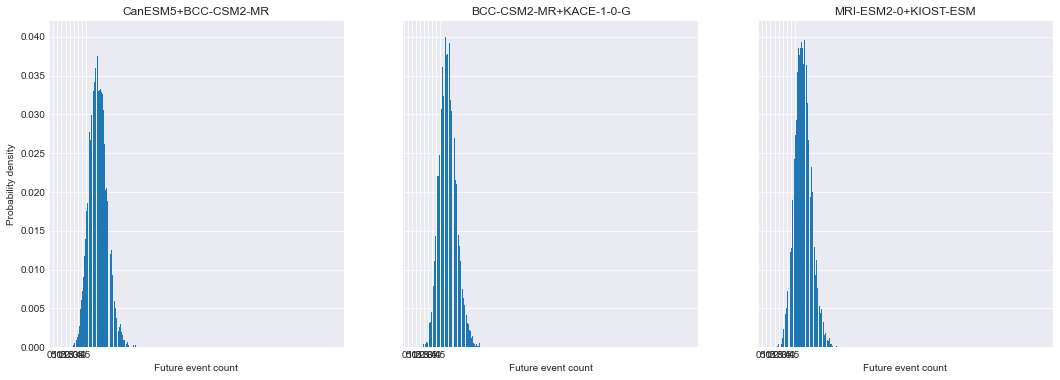

Heat wave
[['CanESM5+BCC-CSM2-MR', array([52, 42, 57, ..., 72, 63, 40])], ['BCC-CSM2-MR+KACE-1-0-G', array([89, 59, 93, ..., 81, 78, 65])], ['MRI-ESM2-0+KIOST-ESM', array([56, 75, 80, ..., 60, 49, 81])]]


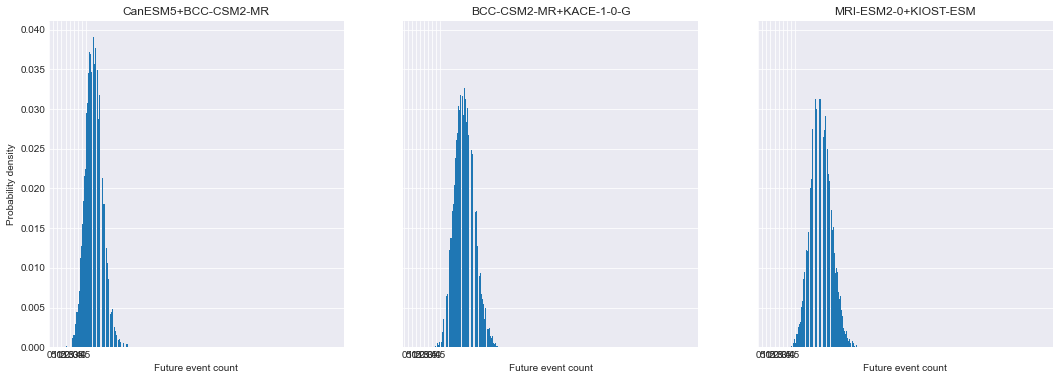

Heat wave
[['CanESM5+BCC-CSM2-MR', array([ 83,  95,  86, ...,  71, 100,  96])], ['BCC-CSM2-MR+KACE-1-0-G', array([114,  94,  89, ..., 100, 104,  94])], ['MRI-ESM2-0+KIOST-ESM', array([ 68, 124, 103, ...,  60,  67, 104])]]


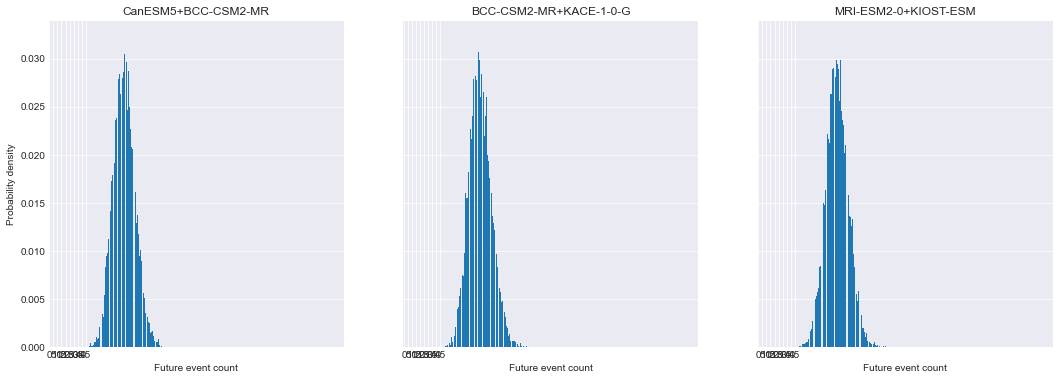

Days warmer than 25
Days warmer than 25
Days warmer than 25
Days warmer than 25
Days warmer than than 95th pctle yearlong
Days warmer than than 95th pctle yearlong
Days warmer than than 95th pctle yearlong
Days warmer than than 95th pctle yearlong
Hottest annual temp
Hottest annual temp
Hottest annual temp
Hottest annual temp
Coldest annual temp
Coldest annual temp
Coldest annual temp
Coldest annual temp
Days colder than than 5th pctle yearlong
Days colder than than 5th pctle yearlong
Days colder than than 5th pctle yearlong
Days colder than than 5th pctle yearlong
Days colder than than 13
Days colder than than 13
Days colder than than 13
Days colder than than 13
Cold wave (10th pctle yearlong)
Cold wave (10th pctle yearlong)
[['BCC-CSM2-MR', array([11,  5,  6, ..., 12,  4,  9])], ['KACE-1-0-G', array([15, 16, 11, ..., 16, 19,  3])], ['KIOST-ESM', array([5, 9, 8, ..., 3, 2, 4])]]


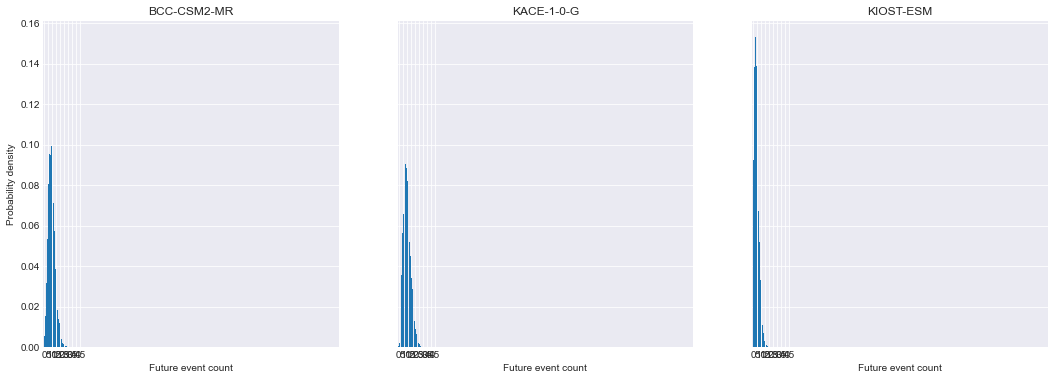

Cold wave (10th pctle yearlong)
[['BCC-CSM2-MR', array([ 5, 13,  5, ...,  5,  6,  1])], ['KACE-1-0-G', array([13,  7, 19, ..., 14, 17, 11])], ['KIOST-ESM', array([8, 3, 9, ..., 7, 9, 5])]]


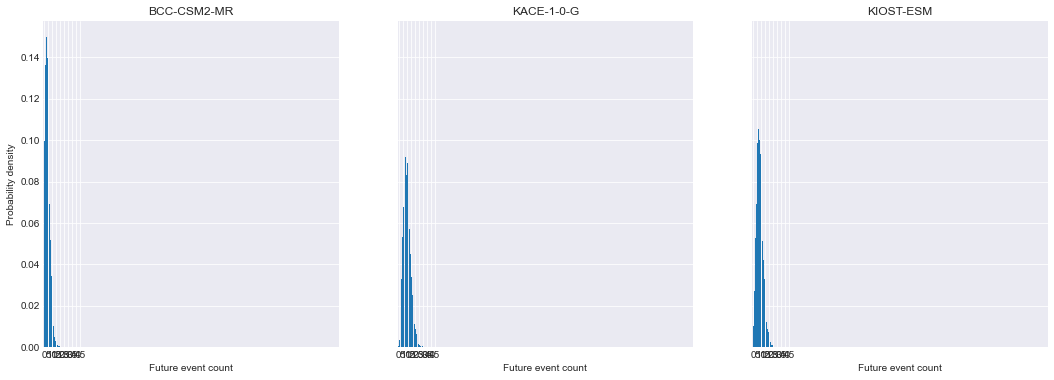

Cold wave (10th pctle yearlong)
[['BCC-CSM2-MR', array([ 5, 16, 11, ...,  5, 12,  7])], ['KACE-1-0-G', array([10,  5,  5, ..., 17,  6,  9])], ['KIOST-ESM', array([14,  6,  8, ...,  4,  9,  5])]]


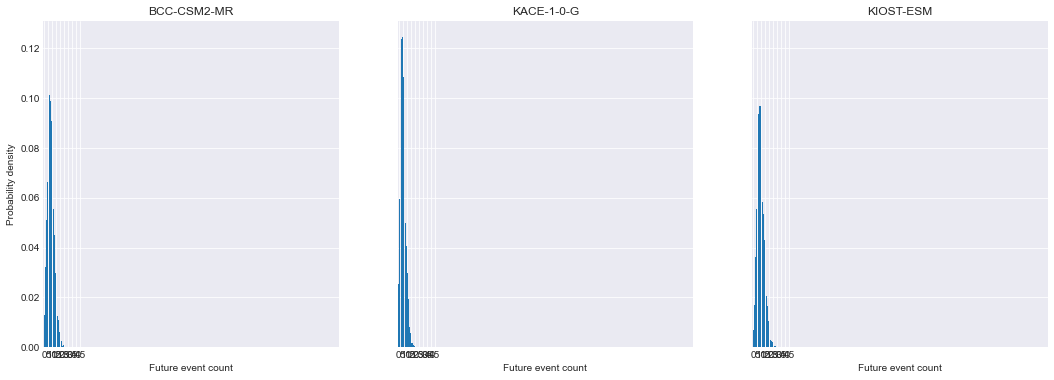

Highest daily precip
CMCC-CM2-SR5 14.54394426702022
UKESM1-0-LL 15.066235100114504
CanESM5 15.367781404671883
Highest daily precip
Highest daily precip
Highest daily precip
Total precip 1-Dec_31-Mar
Total precip 1-Dec_31-Mar
Total precip 1-Dec_31-Mar
Total precip 1-Dec_31-Mar
Extreme precip days
Extreme precip days
Extreme precip days
Extreme precip days
Longest dry 1-May_30-Sep
Longest dry 1-May_30-Sep
Longest dry 1-May_30-Sep
Longest dry 1-May_30-Sep
Longest dry 1-Dec_31-Mar
Longest dry 1-Dec_31-Mar
Longest dry 1-Dec_31-Mar
Longest dry 1-Dec_31-Mar
CPU times: total: 15min 13s
Wall time: 20min 56s


In [188]:
%%time
loc = Location('Campinas_BRA', CAMPINAS_LATLON)
with open('campinas_outputs_alldata_baseline_v4test.csv', 'w') as ofile_all:
    with open('campinas_outputs_headlines_baseline_v4test.csv', 'w') as ofile_headl:
        ofile_all.write('City,Hazard,Years,Model,Q1,Q2,Q3,Param_1,Param_2\n')
        ofile_headl.write('City,Hazard,Years,Q2\n')
        for haz in campinas_hazards:
            for fut_start, fut_end in future_years:
                print(haz['name'])
                est = Estimate(loc, haz['obj'], fut_start, fut_end, haz['is_count'], haz['sh_year'])
                if fut_start == HIST_START and fut_end == HIST_END:
                    res = haz['obj'].baseline(loc, haz['sh_year']) / [1, (HIST_END - HIST_START + [1, 0][int(haz['sh_year'])])][int(haz['is_count'])]
                    ofile_all.write('{0},{1},{2},{3},{4},{5},{6},{7},{8}\n'.format(loc.name, haz['name'], '{0}-{1}'.format(fut_start, fut_end), 'None', None, res, None, haz['params'][0], haz['params'][1]))
                    ofile_headl.write('{0},{1},{2},{3}\n'.format(loc.name, haz['name'], '{0}-{1}'.format(fut_start, fut_end), res))
                else:
                    est = Estimate(loc, haz['obj'], fut_start, fut_end, haz['is_count'], haz['sh_year'])
                    if haz['obj'].probmodel == 'Poisson':
                        est.future_count()
                        vals = []
                        for model in est.estimate:
                            res = list(est.estimate[model])
                            vals.append(res[1])
                            ofile_all.write('{0},{1},{2},{3},{4},{5},{6},{7},{8}\n'.format(loc.name, haz['name'], '{0}-{1}'.format(fut_start, fut_end), model, res[0], res[1], res[2], haz['params'][0], haz['params'][1]))
                        vals.sort()
                        ofile_headl.write('{0},{1},{2},{3}\n'.format(loc.name, haz['name'], '{0}-{1}'.format(fut_start, fut_end), vals[1]))
                    else:
                        est.expected_count()
                        vals = []
                        for model in est.expected_estimate:
                            res = list(est.expected_estimate[model])
                            vals.append(res[1])
                            ofile_all.write('{0},{1},{2},{3},{4},{5},{6},{7},{8}\n'.format(loc.name, haz['name'], '{0}-{1}'.format(fut_start, fut_end), model, res[0], res[1], res[2], haz['params'][0], haz['params'][1]))
                        vals.sort()
                        ofile_headl.write('{0},{1},{2},{3}\n'.format(loc.name, haz['name'], '{0}-{1}'.format(fut_start, fut_end), vals[1]))

In [34]:
for quarter in range(4):
    obs_10 = np.percentile(quarters(hist_obs_tx, HIST_START, HIST_END)[quarter], 10)
    obs_90 = np.percentile(quarters(hist_obs_tx, HIST_START, HIST_END)[quarter], 90)
    for model in best_models_tx:
        mod = quarters(hist_mods_tx[model] - 273.15, HIST_START, HIST_END)[quarter].flatten()
        print('{0}: min modeled value does not exceed observed 10th percentile  {1}'.format(model, min(mod) <= obs_10))
        print('{0}: max modeled value does not exceed observed 90th percentile  {1}'.format(model, max(mod) >= obs_90))


GFDL-CM4: min modeled value does not exceed observed 10th percentile  True
GFDL-CM4: max modeled value does not exceed observed 90th percentile  True
CanESM5: min modeled value does not exceed observed 10th percentile  True
CanESM5: max modeled value does not exceed observed 90th percentile  True
ACCESS-CM2: min modeled value does not exceed observed 10th percentile  True
ACCESS-CM2: max modeled value does not exceed observed 90th percentile  True
GFDL-CM4: min modeled value does not exceed observed 10th percentile  True
GFDL-CM4: max modeled value does not exceed observed 90th percentile  True
CanESM5: min modeled value does not exceed observed 10th percentile  True
CanESM5: max modeled value does not exceed observed 90th percentile  True
ACCESS-CM2: min modeled value does not exceed observed 10th percentile  True
ACCESS-CM2: max modeled value does not exceed observed 90th percentile  True
GFDL-CM4: min modeled value does not exceed observed 10th percentile  True
GFDL-CM4: max modeled